In [96]:
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import copy
import random

SEED = random.randint(1,100) 

Text(0, 0.5, 'X1')

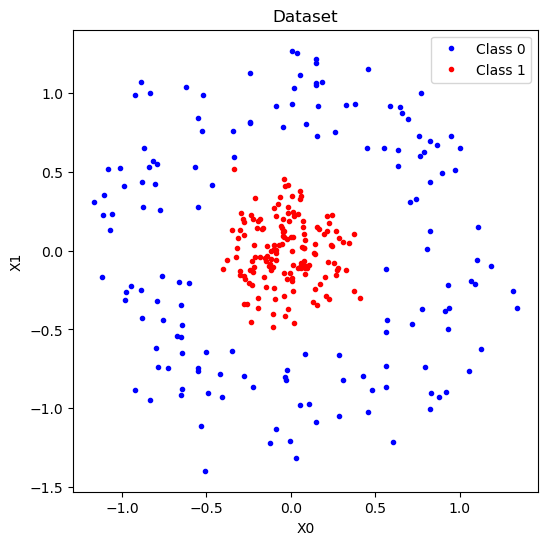

In [97]:
X,y = make_circles(n_samples=300, factor=0.1, noise=0.2,random_state=SEED)
n,s = X.shape
plt.figure(1,figsize=(6,6))
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.b', label='Class 0')
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.r', label='Class 1')
plt.title("Dataset")
plt.legend()
plt.xlabel("X0")
plt.ylabel("X1")

In [98]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

## Network Creation

In [99]:
class InputUnit:
    def __init__(self,data):
        self.data = data        #one column of matrix X
        self.n = data.shape[0]  #dataset size
        self.k = 0              #layer number
        self.z = 0              #unit output

    def plug(self, unit, where = 'following'):
        unit.plug(self, where = where)

    def forward(self,i):
        self.z = self.data[i]
        return self.z


feature_0 = InputUnit(X[:,0])
feature_1 = InputUnit(X[:,1])


In [100]:
class Loss:
    #Constructor
    def __init__(self,y,k):
        self.preceding = [] #list of preceding neurons
        self.npr = 0        #length of list preceding
        self.y = y          #array of class labels of the training data
        self.k = k          #layer index

    def plug(self, unit, where = 'preceding'):
        unit.plug(self,where)


In [101]:
class NeuralUnit:
    #Constructor
    def __init__(self,k,u,seed = SEED):
        self.u = u          #unit number
        self.preceding = [] #list of preceding neurons
        self.npr = 0        #length of list preceding
        self.following = [] #list of following neurons
        self.nfo = 0        #length of list following
        self.k = k          #layer number
        self.w = 0          #unit weights
        self.b = 0          #unit intercept
        self.z = 0          #unit output
        self.rng = np.random.default_rng(seed=seed)

    def reset_params(self):
        self.w = self.rng.standard_normal(self.npr)
        self.b = self.rng.standard_normal()

    def plug(self,unit, where = 'preceding'):   #TODO where=???
        if isinstance(unit,NeuralUnit):
            if where == 'following':
                self.preceding.append(unit)
                unit.following.append(self)
                self.npr += 1
                unit.nfo += 1
                # print(f"{self} is after {unit}")
            elif where == 'preceding':
                self.following.append(unit)
                unit.preceding.append(self)
                self.nfo += 1
                unit.npr += 1
                # print(f"{self} is before {unit}")
        elif isinstance(unit,InputUnit):
            if where == 'following':
                raise Exception("Not possible to add neurone befor the input layer")
            elif where == 'preceding':
                self.preceding.append(unit)
                self.npr += 1
        elif isinstance(unit,Loss):
            if where == 'following':
                raise Exception("Not possible to add neurone after the Loss layer")
            elif where == 'preceding':
                self.following.append(unit)
                self.nfo += 1
                unit.preceding.append(self)
                unit.npr += 1

    def forward(self,i):
        input = np.zeros((self.npr))
        for i,unit in enumerate(self.preceding):
            input[i] = unit.forward()
        
        

        self.z = sigmoid()
        return

In [102]:
class MLP:
#Constructor
    def __init__(self,X,y,archi):
        self.archi = archi
        self.X = X
        self.n = X.shape[0]
        self.y = y
        self.K = len(archi) #number of layers (including input layer but omitting loss layer)
        #creating network

        net = []
        for layer_index in range(self.K):
            layer = []            
            for i in range(archi[layer_index]):
                if layer_index == 0:
                    input_unit = InputUnit(data=X)
                    layer.append(input_unit) #add InputUnit
                else:
                    neural_unit = NeuralUnit(layer_index,u=i)
                    for unit in net[layer_index-1]:
                        unit.plug(neural_unit,where='preceding')
                    neural_unit.reset_params()
                    layer.append(neural_unit)

            net.append(layer)

        layer = [] 
        loss_unit = Loss(y,self.K +1 )
        layer.append(loss_unit)
        for unit in net[-1]:
            loss_unit.plug(unit=unit)
            
        net.append(layer)

        self.net = net

    def visualize(self):
        for i in range(len(self.net)):
            print(f"Layer{i}")
            s=''
            for j in range(len(self.net[i])):
                if i == 0:
                    s += '|I| '
                elif i == len(self.net) -1:
                    s += '|O| '
                else :
                    s += '|N|'
            print(s)
        
        nb_params = 0
        for layer in self.net:
            for unit in layer:
                if isinstance(unit, NeuralUnit):
                    nb_params += len(unit.w) + 1
                    print(unit.w)

        print(f'Nomber of parameters : {nb_params}')


In [103]:
test_mpl = MLP(X=X,y=X,archi=[2,8,8])

test_mpl.visualize()

Layer0
|I| |I| 
Layer1
|N||N||N||N||N||N||N||N|
Layer2
|N||N||N||N||N||N||N||N|
Layer3
|O| 
[-0.73161106 -0.54030449]
[-0.73161106 -0.54030449]
[-0.73161106 -0.54030449]
[-0.73161106 -0.54030449]
[-0.73161106 -0.54030449]
[-0.73161106 -0.54030449]
[-0.73161106 -0.54030449]
[-0.73161106 -0.54030449]
[-0.73161106 -0.54030449 -1.05852538  0.44135857 -0.39553945  0.92432609
  0.95413068 -0.50846383]
[-0.73161106 -0.54030449 -1.05852538  0.44135857 -0.39553945  0.92432609
  0.95413068 -0.50846383]
[-0.73161106 -0.54030449 -1.05852538  0.44135857 -0.39553945  0.92432609
  0.95413068 -0.50846383]
[-0.73161106 -0.54030449 -1.05852538  0.44135857 -0.39553945  0.92432609
  0.95413068 -0.50846383]
[-0.73161106 -0.54030449 -1.05852538  0.44135857 -0.39553945  0.92432609
  0.95413068 -0.50846383]
[-0.73161106 -0.54030449 -1.05852538  0.44135857 -0.39553945  0.92432609
  0.95413068 -0.50846383]
[-0.73161106 -0.54030449 -1.05852538  0.44135857 -0.39553945  0.92432609
  0.95413068 -0.50846383]
[-0.731